# Benchmarking Aura features

In [2]:
import os
import timeit

import numpy as np
import seaborn as sns
from tqdm import tqdm

from graphdatascience.aura_sessions import AuraSessions
from graphdatascience.query_runner.aura_db_arrow_query_runner import AuraDbConnectionInfo

In [3]:
CLIENT_ID = ""
CLIENT_SECRET = ""
DB_PASSWORD = "" 
DB_ID = "5d3bf7f4"
os.environ["AURA_ENV"] = "devstrawberry"

db_connection_info = AuraDbConnectionInfo(
        # f"neo4j+s://{DB_ID}-{os.environ['AURA_ENV']}.databases.neo4j-dev.io", ("neo4j", DB_PASSWORD)
        f"bolt+s://p-5d3bf7f4-ffc6-9.devstrawberry-orch-0001.neo4j-dev.io", ("neo4j", DB_PASSWORD)
    )

In [12]:
sessions = AuraSessions(db_connection_info, (CLIENT_ID, CLIENT_SECRET))
session_name = "benchmark-session"
session_pw = "my-password"

print("Starting GDS session")
if session_name in [i.name for i in sessions.list_sessions()]:
    gds = sessions.connect(session_name, session_pw)
else:
    gds = sessions.create_gds(session_name, session_pw, "24GB")

Starting GDS session


Failed to read from defunct connection IPv4Address(('p-5d3bf7f4-ffc6-9.devstrawberry-orch-0001.neo4j-dev.io', 7687)) (ResolvedIPv4Address(('35.195.234.10', 7687)))


ServiceUnavailable: Failed to read from defunct connection IPv4Address(('p-5d3bf7f4-ffc6-9.devstrawberry-orch-0001.neo4j-dev.io', 7687)) (ResolvedIPv4Address(('35.195.234.10', 7687)))

In [5]:
def measure(func, setup, iterations, warmup_iterations):
    pbar = tqdm(total=iterations + warmup_iterations)
    
    def wrapper():
        value = func()
        pbar.update(1)
        return value
    
    pbar.set_description("Warmup")
    warmup = timeit.repeat(
        wrapper,
        setup=setup,
        number=1,
        repeat=warmup_iterations
    )

    pbar.set_description("Measurment")
    measurement = timeit.repeat(
        wrapper,
        setup=setup,
        number=1,
        repeat=iterations
    )
    
    pbar.close()
    
    return {"iterations": measurement, "mean": np.mean(measurement), "avg": np.average(measurement)}

## Projection

In [6]:
def run_remote_projection(query, concurrency):  
  with gds.graph.project.remoteDb(
        "graph",
        query,
    concurrency=concurrency
    ) as G:
        ()

In [7]:
run_remote_projection(
    """
    CYPHER runtime = parallel
    MATCH (u)
    OPTIONAL MATCH (u)-[r]->(t)
    RETURN gds.graph.project.remote(u, null, {})
    """,
    concurrency=1)


### Project entire graph, structure only

#### No parallel Runtime


Measurment: 100%|██████████| 5/5 [08:52<00:00, 106.54s/it]

Measurment: 100%|██████████| 5/5 [08:05<00:00, 97.01s/it]

Measurment: 100%|██████████| 5/5 [07:57<00:00, 95.48s/it]

Measurment: 100%|██████████| 5/5 [08:13<00:00, 98.72s/it]


[Text(0.5, 0, 'conurrency'), Text(0, 0.5, 'average runtime')]

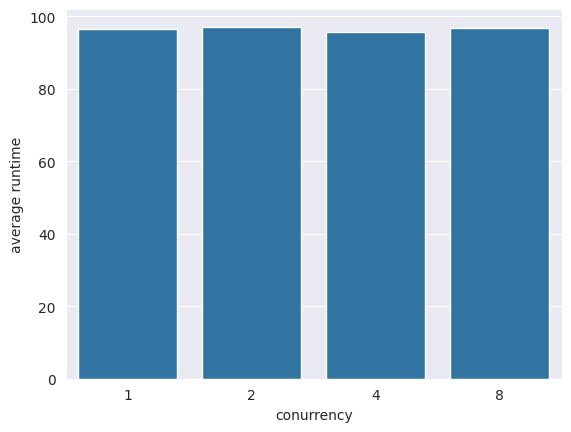

In [12]:
data = {}
for concurrency in [1, 2, 4, 8]:
    result = measure(
                lambda: run_remote_projection(
            """
            MATCH (u)
            OPTIONAL MATCH (u)-[r]->(t)
            RETURN gds.graph.project.remote(u, t, {})
            """,
            concurrency=concurrency
        ),
        lambda: gds.graph.drop("graph", failIfMissing=False),
        iterations=3,
        warmup_iterations=2
    )
    data[concurrency] = result

plot = sns.barplot({k: v["mean"] for k, v in data.items()})
plot.set(xlabel="conurrency", ylabel="average runtime")


#### Parallel Runtime

In [26]:
data = {}
for concurrency in [1, 2, 4, 8]:
    result = measure(
        lambda: run_remote_projection(
            """
            CYPHER runtime = parallel
            MATCH (u)
            OPTIONAL MATCH (u)-[r]->(t)
            RETURN gds.graph.project.remote(u, t, {})
            """,
            concurrency=concurrency
        ),
        lambda: (),
        iterations=1,
        warmup_iterations=1
    )
    data[concurrency] = result

plot = sns.barplot({k: v["mean"] for k, v in data.items()})
plot.set(xlabel="conurrency", ylabel="average runtime")




  0%|          | 0/2 [00:00<?, ?it/s]


Warmup:   0%|          | 0/2 [00:00<?, ?it/s]

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project.remoteDb`: Caused by: java.net.SocketException: Connection reset}

### Project entire graph, with properties and labels

In [ ]:
query = """
            MATCH (u)
            OPTIONAL MATCH (u)-[r]->(t)
            RETURN gds.graph.project.remote(u, t, {
                sourceNodeLabels: labels(u),
                sourceNodeProperties: {id: id(u)},
                targetNodeLabels: labels(t),
                targetNodeProperties: {id: id(t)},
                relationshipType: type(r),
                relationshipProperties: {id: id(r)}
            })
        """

data = {}
for concurrency in [1, 2, 4, 8]:
    result = measure(
        lambda: run_remote_projection(
            query,
            concurrency=concurrency
        ),
        lambda: (),
        iterations=10,
        warmup_iterations=5
    )
    data[concurrency] = result

plot = sns.barplot({k: v["mean"] for k, v in data.items()})
plot.set(xlabel="conurrency", ylabel="average runtime")

## Write back

In [ ]:
G, _ = gds.graph.project.remoteDb(
        "graph",
        """
    CYPHER runtime = parallel
    MATCH (u)
    OPTIONAL MATCH (u)-[r]->(t)
    RETURN gds.graph.project.remote(u, t, {})
    """,
    concurrency=4
    )

gds.degree.mutate(G, mutateProperty="degree")
gds.fastRP.mutate(G, mutateProperty="embedding", embeddingDimension=128, iterationWeights=[1.0])
gds.knn.mutate(G, topK=4, mutateRelationshipType="KNN_RELS", mutateProperty="score", maxIterations=1, nodeProperties=["embedding"])

In [ ]:
result = timeit.repeat(
    lambda: gds.run_cypher("MATCH (n) SET n.degree = null"),
    lambda: gds.graph.nodeProperties.write(G, node_properties=["degree"]), 
    number=1, 
    repeat=iterations)

print(f"scalar property: {result}")

In [ ]:
result = timeit.repeat(
    lambda: gds.run_cypher("MATCH (n) SET n.embedding = null"),
    lambda: gds.graph.nodeProperties.write(G, node_properties=["embedding"]), 
    number=1, 
    repeat=iterations)

print(f"array property: {result}")

In [ ]:
result = timeit.repeat(
    lambda: gds.run_cypher("MATCH (n)-[r:KNN_RELS]->() DELETE r"),
    lambda: gds.graph.relationship.write(G, relationship_type="KNN_RELS", relationship_property="score"), 
    number=1, 
    repeat=iterations)

print(f"relationships: {result}")

## Cleanup

In [ ]:
G.drop()

In [15]:
sessions.delete_gds(session_name)

True

In [ ]:
# cleanup

from graphdatascience.aura_api import AuraApi

aura_api = AuraApi(CLIENT_ID, CLIENT_SECRET)
aura_api.delete_instance(DB_ID)